In [1]:
### 01 SETUP

import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns

load_dotenv()
db = create_engine(os.getenv('DATABASE_URL'))

TOP_N_DISPLAY = 20
TOP_N_EXPORT = 5

MAX_RECIPIENTS_THRESHOLD = 3

# for export
SHADOW_START_DATE = '2000-09-01' 
SHADOW_END_DATE = '2002-02-28'
CRISIS_START_DATE = '2001-10-01'
CRISIS_END_DATE = '2001-11-30'

# for timeline visualization
SHADOW_VIS_START_DATE = SHADOW_START_DATE 
SHADOW_VIS_END_DATE = SHADOW_END_DATE
CRISIS_VIS_START_DATE = SHADOW_START_DATE
CRISIS_VIS_END_DATE = SHADOW_END_DATE

RISK_KEYWORDS = [
    '%shred%', '%destroy%', '%delete%', '%sec%', '%investigation%', 
    '%lawyer%', '%audit%', '%concern%'
]

In [2]:
### 02 Calculate total communication universe

sql_count_true_universe = """
SELECT
    COUNT(DISTINCT email) as total_unique_addresses
FROM (
    SELECT 
        sender_clean as email
    FROM 
        emails_clean
    WHERE 
        sender_clean IS NOT NULL

    UNION

    SELECT 
        unnest(recipients_clean) as email
    FROM 
        emails_clean
    WHERE 
        recipients_clean IS NOT NULL
) as all_addresses;
"""

df_universe_size = pd.read_sql(text(sql_count_true_universe), db)
universe_size = df_universe_size.iloc[0,0]

print(f"Total Enron communication universe (Cleaned) contains {universe_size:,} unique email addresses")

Total Enron communication universe (Cleaned) contains 78,563 unique email addresses


In [3]:
### 03 Identification of Key Personnel

persons_of_interest_names = ['lay', 'skilling', 'fastow']
all_candidates_df = pd.DataFrame()

for name in persons_of_interest_names:
    sql_candidate_dossier = """
        WITH candidates AS (
            SELECT 
                sender_clean as email, 
                MIN(sender) as original_name
            FROM emails_clean
            WHERE sender_clean ILIKE :pattern
            GROUP BY sender_clean
        )
        SELECT 
            c.email,
            c.original_name,
            COALESCE(sent.total_sent, 0) as sent_count,
            COALESCE(received.total_received, 0) as received_count
        FROM 
            candidates c
        LEFT JOIN (
            SELECT sender, SUM(message_count) as total_sent
            FROM communication_network
            GROUP BY sender
        ) sent ON c.email = sent.sender
        LEFT JOIN (
            SELECT recipient, SUM(message_count) as total_received
            FROM communication_network
            GROUP BY recipient
        ) received ON c.email = received.recipient
        ORDER BY
            (COALESCE(sent.total_sent, 0) + COALESCE(received.total_received, 0)) DESC;
    """
    
    print(f"\n--- Candidates for '{name.capitalize()}' ---")
    df_candidates = pd.read_sql(
        text(sql_candidate_dossier),
        db,
        params={'pattern': f'%{name}%'}
    )
    
    if df_candidates.empty:
        print("  None found.")
    else:
        display(df_candidates)


--- Candidates for 'Lay' ---


,email,original_name,sent_count,received_count
0,kenneth.lay@enron.com,kenneth.lay@enron.com,17.0,1046.0
1,l..nicolay@enron.com,l..nicolay@enron.com,194.0,251.0
2,christi.nicolay@enron.com,christi.nicolay@enron.com,248.0,139.0
3,clayton.vernon@enron.com,clayton.vernon@enron.com,33.0,43.0
4,jennifer.blay@enron.com,jennifer.blay@enron.com,15.0,34.0
5,ernie.j.zavaleta@fritolay.com,ernie.j.zavaleta@fritolay.com,24.0,17.0
6,mark.lay@enron.com,mark.lay@enron.com,15.0,25.0
7,wincash@play4keeps.com,wincash@play4keeps.com,35.0,0.0
8,clay.harris@enron.com,clay.harris@enron.com,13.0,17.0
9,laynie.east@enron.com,laynie.east@enron.com,21.0,8.0



--- Candidates for 'Skilling' ---


,email,original_name,sent_count,received_count
0,jeff.skilling@enron.com,jeff.skilling@enron.com,62.0,975.0
1,markskilling@hotmail.com,markskilling@hotmail.com,41.0,24.0
2,tskilling@tribune.com,tskilling@tribune.com,5.0,13.0
3,jeffreyskilling@yahoo.com,jeffreyskilling@yahoo.com,3.0,1.0
4,skilling@enron.com,skilling@enron.com,1.0,2.0
5,mark.skilling@enron.com,mark.skilling@enron.com,1.0,0.0



--- Candidates for 'Fastow' ---


,email,original_name,sent_count,received_count
0,andrew.fastow@enron.com,andrew.fastow@enron.com,8.0,27.0
1,lfastow@pop.pdq.net,lfastow@pop.pdq.net,8.0,4.0
2,lfastow@pdq.net,lfastow@pdq.net,2.0,2.0


In [4]:
### 04 Manually define seed addresses

seeds = {
    'CEO': 'kenneth.lay@enron.com',
    'COO': 'jeff.skilling@enron.com',
    'CFO': 'andrew.fastow@enron.com'
}
seed_emails = list(seeds.values())

print("Proceeding with the following manually verified seeds:")
for role, email in seeds.items():
    print(f"- {role}: {email}")

Proceeding with the following manually verified seeds:
- CEO: kenneth.lay@enron.com
- COO: jeff.skilling@enron.com
- CFO: andrew.fastow@enron.com


In [5]:
### 05 Count emails sent by seeds

sql_chief_counts = """
SELECT
    sender_clean,
    COUNT(*) as email_count
FROM
    emails_clean
WHERE
    sender_clean IN :seeds
GROUP BY
    sender_clean
ORDER BY
    email_count DESC;
"""

print("Counting sent emails for the identified seeds...")
df_chief_counts = pd.read_sql(text(sql_chief_counts), db, params={'seeds': tuple(seed_emails)})
display(df_chief_counts)

Counting sent emails for the identified seeds...


,sender_clean,email_count
0,jeff.skilling@enron.com,66
1,kenneth.lay@enron.com,22
2,andrew.fastow@enron.com,8


In [6]:
### 06 Detailed sender/receiver analysis for seeds

def analyze_executive_communication(target_email):
    # sent e-mails
    sql_sent = text("""
        SELECT 
            unnest(recipients_clean) AS recipient, 
            COUNT(*) AS count
        FROM emails_clean
        WHERE 
            sender_clean = :email
            AND cardinality(recipients_clean) <= :max_recip 
        GROUP BY recipient
        ORDER BY count DESC
        LIMIT :limit;
    """)
    
    df_sent = pd.read_sql(
        sql_sent, 
        db, 
        params={
            "email": target_email, 
            "limit": TOP_N_DISPLAY, 
            "max_recip": MAX_RECIPIENTS_THRESHOLD
        }
    )

    # received e-mails
    sql_received = text("""
        SELECT 
            sender_clean AS sender, 
            COUNT(*) AS count
        FROM emails_clean
        WHERE 
            :email = ANY(recipients_clean)
        GROUP BY sender_clean
        ORDER BY count DESC
        LIMIT :limit;
    """)
    
    df_received = pd.read_sql(
        sql_received, 
        db, 
        params={
            "email": target_email, 
            "limit": TOP_N_DISPLAY
        }
    )

    return df_sent, df_received

print(f"Starting detailed analysis for seeds (filter: max {MAX_RECIPIENTS_THRESHOLD} recipients)...\n")

for role, email in seeds.items():
    sent_df, received_df = analyze_executive_communication(email)
    
    print("-" * 60)
    print(f"Analysis for: {role} ({email})")
    print("-" * 60)
    
    print(f"1. Top {TOP_N_DISPLAY} recipients (sent by seed):")
    if sent_df.empty:
        print("   No relevant mails sent.")
    else:
        display(sent_df)
        
    print(f"\n2. Top {TOP_N_DISPLAY} Sender (addressed to seed):")
    if received_df.empty:
        print("   No relevant mails received.")
    else:
        display(received_df)
    print("\n")

Starting detailed analysis for seeds (filter: max 3 recipients)...

------------------------------------------------------------
Analysis for: CEO (kenneth.lay@enron.com)
------------------------------------------------------------
1. Top 20 recipients (sent by seed):


,recipient,count
0,mccann@nc.rr.com,1
1,michelle.cash@enron.com,1
2,linda.robertson@enron.com,1
3,j..kean@enron.com,1
4,wired@condenast.flonetwork.com,1
5,christie.patrick@enron.com,1
6,scc@rice.edu,1
7,e..haedicke@enron.com,1
8,lhjamail@aol.com,1
9,benjamin.rogers@enron.com,1



2. Top 20 Sender (addressed to seed):


,sender,count
0,leonardo.pacheco@enron.com,64
1,kenneth.thibodeaux@enron.com,61
2,joannie.williamson@enron.com,47
3,karen.denne@enron.com,45
4,simone.la@enron.com,35
5,simone.rose@enron.com,31
6,rosalee.fleming@enron.com,28
7,steven.kean@enron.com,27
8,fraisy.george@enron.com,23
9,j..kean@enron.com,21




------------------------------------------------------------
Analysis for: COO (jeff.skilling@enron.com)
------------------------------------------------------------
1. Top 20 recipients (sent by seed):


,recipient,count
0,eharris@insightpartners.com,5
1,sherri.sera@enron.com,5
2,kcompton@kpcb.com,4
3,stanmarek@marekbros.com,4
4,kevin.hannon@enron.com,3
5,dottie@kerr-solutions.com,3
6,david.delainey@enron.com,3
7,jeff_donahue@enron.net,2
8,expense.report@enron.com,2
9,isc.hotline@enron.com,2



2. Top 20 Sender (addressed to seed):


,sender,count
0,leonardo.pacheco@enron.com,64
1,kenneth.thibodeaux@enron.com,41
2,simone.la@enron.com,35
3,simone.rose@enron.com,32
4,lisa.connolly@enron.com,30
5,markskilling@hotmail.com,23
6,steven.kean@enron.com,20
7,karen.denne@enron.com,20
8,katherine.brown@enron.com,19
9,billy.lemmons@enron.com,17




------------------------------------------------------------
Analysis for: CFO (andrew.fastow@enron.com)
------------------------------------------------------------
1. Top 20 recipients (sent by seed):


,recipient,count
0,jeff.skilling@enron.com,3
1,louise.kitchen@enron.com,3
2,greg.whalley@enron.com,1
3,john.lavorato@enron.com,1



2. Top 20 Sender (addressed to seed):


,sender,count
0,joannie.williamson@enron.com,29
1,katherine.brown@enron.com,19
2,billy.lemmons@enron.com,12
3,ginger.dernehl@enron.com,11
4,rosalee.fleming@enron.com,11
5,maureen.mcvicker@enron.com,10
6,billy.dorsey@enron.com,9
7,paula.rieker@enron.com,9
8,vanessa.groscrand@enron.com,7
9,karen.myer@enron.com,7


In [7]:
# There is a suspiciously low number of emails sent by the chiefs.
# Possible reasons:
# - Communication via other channels
# - Gatekeeper
# - Destruction of evidence

# Therefore the focus shifts to the communication network around the C-suite.

In [8]:
### 07 Build the 'Circle of Interest' (Levels 0, 1, 2)

print(f"Starting multi-level network analysis with {len(seed_emails)} Seeds: {seed_emails}")
print("-" * 50)

sql_build_circle = """
DROP TABLE IF EXISTS circle_of_interest;
CREATE TABLE circle_of_interest (
    email TEXT PRIMARY KEY,
    level INTEGER
);
"""

sql_insert_level0 = "INSERT INTO circle_of_interest (email, level) SELECT unnest(:seeds), 0;"

sql_insert_level1 = """
INSERT INTO circle_of_interest (email, level)
SELECT DISTINCT person, 1
FROM (
    SELECT recipient as person FROM communication_network WHERE sender IN (SELECT email FROM circle_of_interest WHERE level = 0)
    UNION
    SELECT sender as person FROM communication_network WHERE recipient IN (SELECT email FROM circle_of_interest WHERE level = 0)
) as level1_contacts
ON CONFLICT (email) DO NOTHING;
"""

sql_insert_level2 = """
INSERT INTO circle_of_interest (email, level)
SELECT DISTINCT person, 2
FROM (
    SELECT recipient as person FROM communication_network WHERE sender IN (SELECT email FROM circle_of_interest WHERE level = 1)
    UNION
    SELECT sender as person FROM communication_network WHERE recipient IN (SELECT email FROM circle_of_interest WHERE level = 1)
) as level2_contacts
ON CONFLICT (email) DO NOTHING;
"""

print("Building 'Circle of Interest'...")
start_time = time.time()

with db.connect() as conn:
    conn.execute(text(sql_build_circle))
    conn.execute(text(sql_insert_level0), {'seeds': seed_emails})
    print("Level 0 (Seeds) inserted.")

    conn.execute(text(sql_insert_level1))
    print("Level 1 (Direct Contacts) identified.")
    
    conn.execute(text(sql_insert_level2))
    print("Level 2 (Extended Network) identified.")
    
    conn.commit()

print(f"Finished in {time.time() - start_time:.2f}s.")
print("-" * 50)

# --- Statistics ---
df_circle_stats = pd.read_sql("SELECT level, COUNT(*) as person_count FROM circle_of_interest GROUP BY level ORDER BY level", db)
total_circle_size = df_circle_stats['person_count'].sum()

print(f"Final Network Size: {total_circle_size} Persons.")
display(df_circle_stats)

Starting multi-level network analysis with 3 Seeds: ['kenneth.lay@enron.com', 'jeff.skilling@enron.com', 'andrew.fastow@enron.com']
--------------------------------------------------
Building 'Circle of Interest'...
Level 0 (Seeds) inserted.
Level 1 (Direct Contacts) identified.
Level 2 (Extended Network) identified.
Finished in 0.26s.
--------------------------------------------------
Final Network Size: 7830 Persons.


,level,person_count
0,0,3
1,1,1170
2,2,6657


In [9]:
### 08 Rank communication volume within the circle

# 1. Level 0 <-> level 1 communication
sql_rank_l1 = """
SELECT
    CASE
        WHEN sender IN :seeds THEN recipient
        ELSE sender
    END as level1_contact,
    CAST(SUM(message_count) AS INTEGER) as total_exchange_with_c_suite
FROM
    communication_network
WHERE
    (sender IN :seeds AND recipient IN (SELECT email FROM circle_of_interest WHERE level = 1))
    OR
    (recipient IN :seeds AND sender IN (SELECT email FROM circle_of_interest WHERE level = 1))
GROUP BY
    level1_contact
ORDER BY
    total_exchange_with_c_suite DESC
LIMIT :limit;
"""

print(f"Top {TOP_N_DISPLAY} L1 contacts communicating with C-suite ---")
df_ranked_l1 = pd.read_sql(
    text(sql_rank_l1),
    db,
    params={'seeds': tuple(seed_emails), 'limit': TOP_N_DISPLAY}
)
display(df_ranked_l1)


# 2. Level 1 <-> level 2 communication
sql_rank_l2 = """
SELECT
    CASE
        WHEN sender IN (SELECT email FROM circle_of_interest WHERE level = 1) THEN recipient
        ELSE sender
    END as level2_contact,
    CAST(SUM(message_count) AS INTEGER) as total_exchange_with_level1
FROM
    communication_network
WHERE
    (sender IN (SELECT email FROM circle_of_interest WHERE level = 1) AND recipient IN (SELECT email FROM circle_of_interest WHERE level = 2))
    OR
    (recipient IN (SELECT email FROM circle_of_interest WHERE level = 1) AND sender IN (SELECT email FROM circle_of_interest WHERE level = 2))
GROUP BY
    level2_contact
ORDER BY
    total_exchange_with_level1 DESC
LIMIT :limit;
"""

print(f"\nTop {TOP_N_DISPLAY} L2 contacts communicating with L1")
df_ranked_l2 = pd.read_sql(
    text(sql_rank_l2),
    db,
    params={'limit': TOP_N_DISPLAY}
)
display(df_ranked_l2)

Top 20 L1 contacts communicating with C-suite ---


,level1_contact,total_exchange_with_c_suite
0,steven.kean@enron.com,39
1,lisa.connolly@enron.com,30
2,karen.denne@enron.com,25
3,david.delainey@enron.com,23
4,svarga@kudlow.com,22
5,j..kean@enron.com,16
6,enron_update@concureworkplace.com,15
7,terrie.james@enron.com,14
8,kevinscott@onlinemailbox.net,14
9,christie.patrick@enron.com,13



Top 20 L2 contacts communicating with L1


,level2_contact,total_exchange_with_level1
0,vkaminski@aol.com,1664
1,mike.maggi@enron.com,947
2,susan.mara@enron.com,816
3,james.steffes@enron.com,741
4,d..steffes@enron.com,684
5,kay.mann@enron.com,666
6,shirley.crenshaw@enron.com,560
7,mark.haedicke@enron.com,364
8,joseph.alamo@enron.com,361
9,richard.sanders@enron.com,295


In [10]:
### 09 Calculate communication volume within the circle

sql_circle_traffic_only = """
SELECT
    COUNT(DISTINCT email_id) as internal_circle_mails
FROM
    communication_links
WHERE
    sender IN (SELECT email FROM circle_of_interest)
    AND recipient IN (SELECT email FROM circle_of_interest);
"""

print("Counting emails exchanged exclusively within the 'Circle of Interest'...")
df_circle_traffic = pd.read_sql(text(sql_circle_traffic_only), db)
internal_circle_mails = df_circle_traffic.iloc[0,0]

sql_total_clean = "SELECT COUNT(*) FROM emails_clean"
total_clean_mails = pd.read_sql(text(sql_total_clean), db).iloc[0,0]

if total_clean_mails > 0:
    percentage_internal = (internal_circle_mails / total_clean_mails) * 100
else:
    percentage_internal = 0

print("-" * 50)
print(f"Total unique emails in dataset: {total_clean_mails:,}") 
print(f"Emails strictly internal within the 'Circle of Interest': {internal_circle_mails:,}")
print(f"This represents {percentage_internal:.2f}% of the total traffic.")
print("-" * 50)

Counting emails exchanged exclusively within the 'Circle of Interest'...
--------------------------------------------------
Total unique emails in dataset: 248,940
Emails strictly internal within the 'Circle of Interest': 124,843
This represents 50.15% of the total traffic.
--------------------------------------------------


In [11]:
### 10 Assessing off-hour communication

sql_off_hours = """
SELECT 
    COUNT(*) AS off_hour_mails
FROM emails_clean
WHERE 
    sent_at_local IS NOT NULL AND (
        -- Night (7 PM - 7 AM)
        EXTRACT(HOUR FROM sent_at_local) >= 19 
        OR EXTRACT(HOUR FROM sent_at_local) < 7
    )
    OR
    EXTRACT(ISODOW FROM sent_at_local) IN (6, 7);
"""
df_offtime = pd.read_sql(text(sql_off_hours), db)
off_hour_count = df_offtime.iloc[0,0]

sql_total = "SELECT COUNT(*) FROM emails_clean WHERE sent_at_local IS NOT NULL;"
df_total = pd.read_sql(text(sql_total), db)
total_count = df_total.iloc[0,0]

if total_count > 0:
    percentage = (off_hour_count / total_count) * 100
else:
    percentage = 0

print("Off-Hour communication analysis results")
print(f"Total emails with valid timestamps: {total_count}")
print(f"Emails sent during off-hours or weekends: {off_hour_count}")
print(f"Percentage of off-hour communication: {percentage:.2f}%")

summary_df = pd.DataFrame({
    'Metric': ['Total Mails (with date)', 'Off-Hour mails', 'Percentage'],
    'Value': [total_count, off_hour_count, f"{percentage:.2f}%"]
})
display(summary_df)

Off-Hour communication analysis results
Total emails with valid timestamps: 248702
Emails sent during off-hours or weekends: 100695
Percentage of off-hour communication: 40.49%


,Metric,Value
0,Total Mails (with date),248702
1,Off-Hour mails,100695
2,Percentage,40.49%


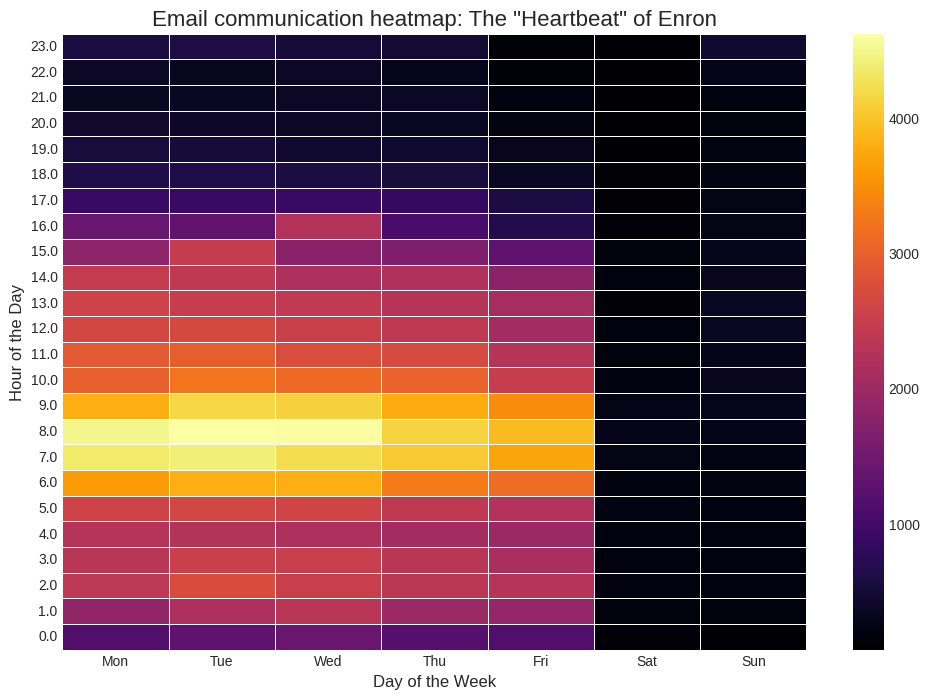

In [12]:
### 11 working hours at Enron (wall clock-Heatmap)

sql_get_timestamps = """
SELECT
    EXTRACT(ISODOW FROM sent_at_local) as weekday,
    EXTRACT(HOUR FROM sent_at_local) as hour
FROM
    emails_clean
WHERE
    sent_at_local IS NOT NULL;
"""

df_timestamps = pd.read_sql(text(sql_get_timestamps), db)

heatmap_data = df_timestamps.groupby(['hour', 'weekday']).size().unstack(fill_value=0)

heatmap_data = heatmap_data.reindex(columns=range(1, 8))

weekday_map = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat', 7: 'Sun'}
heatmap_data.columns = heatmap_data.columns.map(weekday_map)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(
    heatmap_data, 
    cmap="inferno",
    linewidths=.5, 
    annot=False,
    ax=ax
)

ax.set_title('Email communication heatmap: The "Heartbeat" of Enron', fontsize=16)
ax.set_xlabel('Day of the Week', fontsize=12)
ax.set_ylabel('Hour of the Day', fontsize=12)
ax.invert_yaxis()
plt.show()

fig.savefig("analysis_results/heatmap_work_week.png")

In [13]:
### 12 Identifying the "Night-Owls"

sql_night_owls = """
SELECT
    sender_clean,
    COUNT(*) as night_mail_count
FROM
    emails_clean
WHERE
    EXTRACT(HOUR FROM sent_at_local) BETWEEN 0 AND 5
    AND sender_clean IS NOT NULL
GROUP BY
    sender_clean
ORDER BY
    night_mail_count DESC
LIMIT 20;
"""

print("Top 20 'Night Owl' senders (Midnight to 6 AM)")
df_night_owls = pd.read_sql(text(sql_night_owls), db)
display(df_night_owls)

Top 20 'Night Owl' senders (Midnight to 6 AM)


,sender_clean,night_mail_count
0,kay.mann@enron.com,2313
1,sara.shackleton@enron.com,2016
2,tana.jones@enron.com,1795
3,vince.kaminski@enron.com,1739
4,jeff.dasovich@enron.com,1608
5,chris.germany@enron.com,1193
6,matthew.lenhart@enron.com,1186
7,eric.bass@enron.com,902
8,debra.perlingiere@enron.com,900
9,pete.davis@enron.com,889


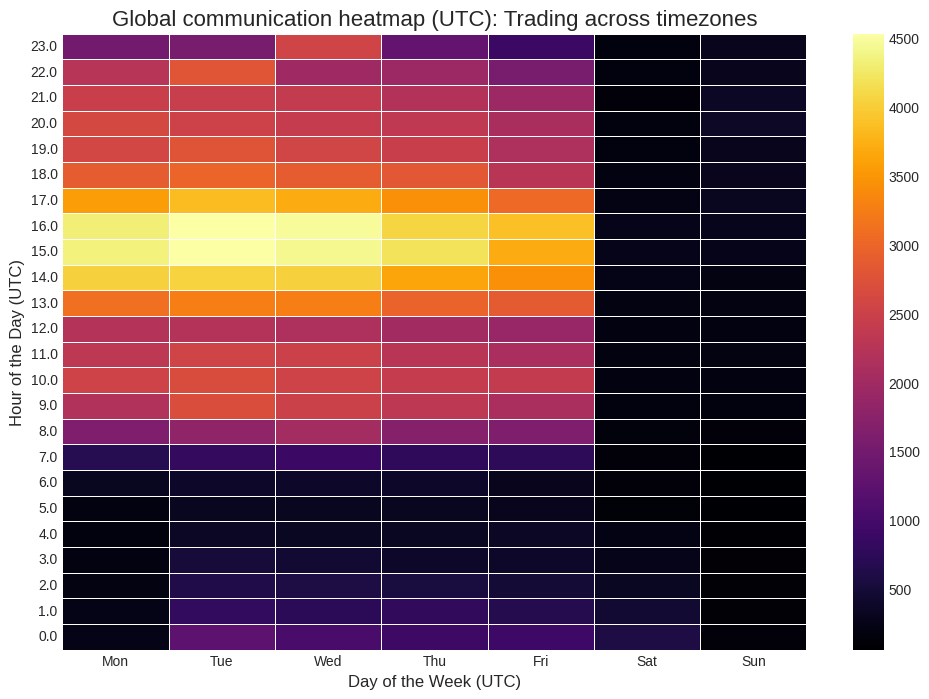

In [14]:
### 13 working hours (UTC-heatmap)

sql_get_timestamps_utc = """
SELECT
    EXTRACT(ISODOW FROM sent_at_utc) as weekday,
    EXTRACT(HOUR FROM sent_at_utc) as hour
FROM
    emails_clean
WHERE
    sent_at_utc IS NOT NULL;
"""

df_timestamps_utc = pd.read_sql(text(sql_get_timestamps_utc), db)

heatmap_data_utc = df_timestamps_utc.groupby(['hour', 'weekday']).size().unstack(fill_value=0)
heatmap_data_utc = heatmap_data_utc.reindex(columns=range(1, 8))
weekday_map = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat', 7: 'Sun'}
heatmap_data_utc.columns = heatmap_data_utc.columns.map(weekday_map)

fig_utc, ax_utc = plt.subplots(figsize=(12, 8))

sns.heatmap(
    heatmap_data_utc, 
    cmap="inferno",
    linewidths=.5, 
    ax=ax_utc
)

ax_utc.set_title('Global communication heatmap (UTC): Trading across timezones', fontsize=16)
ax_utc.set_xlabel('Day of the Week (UTC)', fontsize=12)
ax_utc.set_ylabel('Hour of the Day (UTC)', fontsize=12)
ax_utc.invert_yaxis()
plt.show()

fig_utc.savefig("analysis_results/heatmap_global_utc.png")

In [15]:
### 14 Export for Tableau: heatmap data (multi-timezone pre-calculation)

output_dir = "analysis_results"
os.makedirs(output_dir, exist_ok=True)

sql_heatmap_multi = """
-- 1. UTC 
SELECT
    '1. UTC (Global)' as time_view,
    CAST(EXTRACT(ISODOW FROM sent_at_utc) AS INTEGER) as weekday_num,
    TRIM(TO_CHAR(sent_at_utc, 'Day')) as weekday_name,
    CAST(EXTRACT(HOUR FROM sent_at_utc) AS INTEGER) as hour_of_day,
    COUNT(*) as email_count
FROM emails_clean WHERE sent_at_utc IS NOT NULL
GROUP BY 2, 3, 4

UNION ALL

-- 2. Portland (West Coast / US Pacific) - 'America/Los_Angeles'
SELECT
    '2. Portland (West Desk)' as time_view,
    CAST(EXTRACT(ISODOW FROM (sent_at_utc AT TIME ZONE 'America/Los_Angeles')) AS INTEGER) as weekday_num,
    TRIM(TO_CHAR((sent_at_utc AT TIME ZONE 'America/Los_Angeles'), 'Day')) as weekday_name,
    CAST(EXTRACT(HOUR FROM (sent_at_utc AT TIME ZONE 'America/Los_Angeles')) AS INTEGER) as hour_of_day,
    COUNT(*) as email_count
FROM emails_clean WHERE sent_at_utc IS NOT NULL
GROUP BY 2, 3, 4

UNION ALL

-- 3. Houston (HQ / US Central) - 'America/Chicago'
SELECT
    '3. Houston (HQ)' as time_view,
    CAST(EXTRACT(ISODOW FROM (sent_at_utc AT TIME ZONE 'America/Chicago')) AS INTEGER) as weekday_num,
    TRIM(TO_CHAR((sent_at_utc AT TIME ZONE 'America/Chicago'), 'Day')) as weekday_name,
    CAST(EXTRACT(HOUR FROM (sent_at_utc AT TIME ZONE 'America/Chicago')) AS INTEGER) as hour_of_day,
    COUNT(*) as email_count
FROM emails_clean WHERE sent_at_utc IS NOT NULL
GROUP BY 2, 3, 4

UNION ALL

-- 4. London (Europe) - 'Europe/London'
SELECT
    '4. London (Europe)' as time_view,
    CAST(EXTRACT(ISODOW FROM (sent_at_utc AT TIME ZONE 'Europe/London')) AS INTEGER) as weekday_num,
    TRIM(TO_CHAR((sent_at_utc AT TIME ZONE 'Europe/London'), 'Day')) as weekday_name,
    CAST(EXTRACT(HOUR FROM (sent_at_utc AT TIME ZONE 'Europe/London')) AS INTEGER) as hour_of_day,
    COUNT(*) as email_count
FROM emails_clean WHERE sent_at_utc IS NOT NULL
GROUP BY 2, 3, 4

UNION ALL

-- 5. Sender's local time
SELECT
    '5. Sender''s Local Time' as time_view,
    CAST(EXTRACT(ISODOW FROM sent_at_local) AS INTEGER) as weekday_num,
    TRIM(TO_CHAR(sent_at_local, 'Day')) as weekday_name,
    CAST(EXTRACT(HOUR FROM sent_at_local) AS INTEGER) as hour_of_day,
    COUNT(*) as email_count
FROM emails_clean WHERE sent_at_local IS NOT NULL
GROUP BY 2, 3, 4

ORDER BY 1, 2, 4;
"""

print("Exporting multi-timezone heatmap data...")
df_heatmap_multi = pd.read_sql(text(sql_heatmap_multi), db)

export_path = os.path.join(output_dir, "heatmap_multi_view.csv")
df_heatmap_multi.to_csv(export_path, index=False)

print(f"Export complete. {len(df_heatmap_multi)} rows written to '{export_path}'.")
print(f"Views generated: {df_heatmap_multi['time_view'].unique()}")

Exporting multi-timezone heatmap data...
Export complete. 840 rows written to 'analysis_results/heatmap_multi_view.csv'.
Views generated: ['1. UTC (Global)' '2. Portland (West Desk)' '3. Houston (HQ)'
 '4. London (Europe)' "5. Sender's Local Time"]


In [16]:
# When looking at the heat maps for the different time zones, it is noticeable that the view ‘Sender's Local Time’, which is particularly important for behavioural analysis, corresponds exactly to ‘Portland’.

In [17]:
### 15 Display all time zones occurring in the dataset
sql_check_timezones = """
SELECT
    RIGHT(date_raw, 12) as timezone_suffix,
    COUNT(*) as count
FROM
    emails_clean
GROUP BY
    timezone_suffix
ORDER BY
    count DESC;
"""

print("Check the time zone distribution in the dataset...")
df_timezones = pd.read_sql(text(sql_check_timezones), db)
display(df_timezones)

Check the time zone distribution in the dataset...


,timezone_suffix,count
0,-0700 (PDT),130781
1,-0800 (PST),118159


In [18]:
# A review of all time zones in the database reveals that the entire data set has been standardised to West Coast time, which means that a behavioural analysis as originally planned is no longer possible.
# Instead, the heat maps show time periods during which there is hardly any communication. Activities during these times are worth considering.

Generating 'Shadow Timeline' analysis (absolute and relative)...


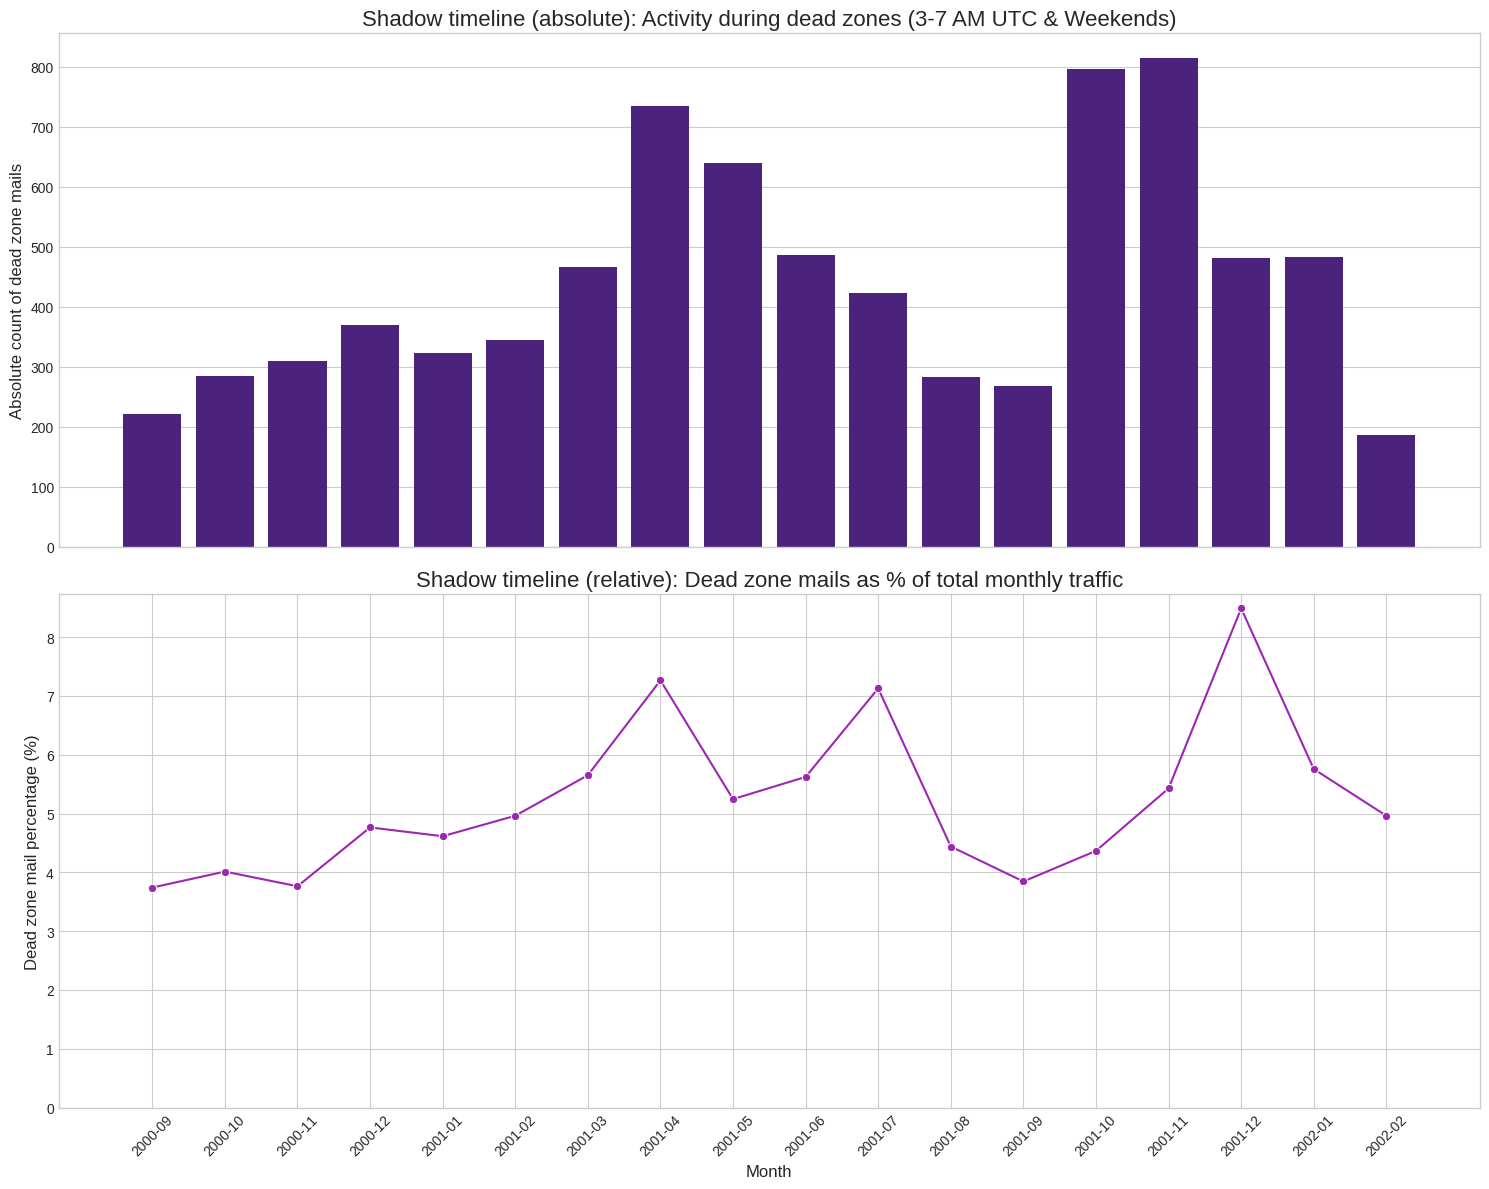

Data exported to analysis_results/shadow_timeline_combined.csv
Combined chart image saved.


In [19]:
### 16 The 'Shadow Timeline' (Dead Zone Activity)

# Hypothesis: Activity during periods of absolute rest (3-7 a.m. & weekends)
# within the inner circle indicates extreme urgency.

SHADOW_START_HOUR = 3
SHADOW_END_HOUR = 6
SHADOW_WEEKEND_DAYS = (6, 7)

sql_shadow_timeline_combined = """
WITH monthly_traffic AS (
    SELECT
        TO_CHAR(sent_at_utc, 'YYYY-MM') as month,
        COUNT(*) FILTER (
            WHERE EXTRACT(HOUR FROM sent_at_utc) BETWEEN :start_hour AND :end_hour
               OR EXTRACT(ISODOW FROM sent_at_utc) IN :weekend_days
        ) as dead_zone_mail_count,
        COUNT(*) as total_mail_count
    FROM
        emails_clean
    WHERE
        sender_clean IN (SELECT email FROM circle_of_interest)
        AND sent_at_utc BETWEEN :start_date AND :end_date
    GROUP BY
        month
)
SELECT
    month,
    dead_zone_mail_count,
    total_mail_count,
    (dead_zone_mail_count::FLOAT / NULLIF(total_mail_count, 0)) * 100 as dead_zone_percentage
FROM
    monthly_traffic
ORDER BY
    month;
"""

print("Generating 'Shadow Timeline' analysis (absolute and relative)...")
df_shadow_timeline = pd.read_sql(
    text(sql_shadow_timeline_combined), 
    db,
    params={
        'start_date': SHADOW_VIS_START_DATE,
        'end_date': SHADOW_VIS_END_DATE,
        'start_hour': SHADOW_START_HOUR,
        'end_hour': SHADOW_END_HOUR,
        'weekend_days': SHADOW_WEEKEND_DAYS
    }
)

plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# Absolute plot
sns.barplot(data=df_shadow_timeline, x='month', y='dead_zone_mail_count', color='#4a148c', ax=ax1)
ax1.set_title(
    f"Shadow timeline (absolute): Activity during dead zones "
    f"({SHADOW_START_HOUR}-{SHADOW_END_HOUR+1} AM UTC & Weekends)",
    fontsize=16
)
ax1.set_ylabel('Absolute count of dead zone mails', fontsize=12)

# Relative plot
sns.lineplot(data=df_shadow_timeline, x='month', y='dead_zone_percentage', marker='o', color='#9c27b0', ax=ax2)
ax2.set_title('Shadow timeline (relative): Dead zone mails as % of total monthly traffic', fontsize=16)
ax2.set_xlabel('Month', fontsize=12)
ax2.set_ylabel('Dead zone mail percentage (%)', fontsize=12)
ax2.set_ylim(0)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Export combined data and chart
export_path = "analysis_results/shadow_timeline_combined.csv"
df_shadow_timeline.to_csv(export_path, index=False)
print(f"Data exported to {export_path}")
fig.savefig("analysis_results/shadow_timeline_combined.png")
print("Combined chart image saved.")

In [20]:
### 17 Identify top shadow actors

sql_top_shadow_senders = """
SELECT 
    sender_clean as sender,
    COUNT(*) as dead_zone_mail_count
FROM 
    emails_clean
WHERE
    sender_clean IN (SELECT email FROM circle_of_interest)
    AND sent_at_utc BETWEEN :start_date AND :end_date
    AND (
        EXTRACT(HOUR FROM sent_at_utc) BETWEEN :start_hour AND :end_hour
        OR EXTRACT(ISODOW FROM sent_at_utc) IN :weekend_days
    )
GROUP BY 
    sender_clean
ORDER BY 
    dead_zone_mail_count DESC
LIMIT :limit;
"""

print(f"Identify top {TOP_N_DISPLAY} 'shadow actors' (03:00-07:00) in the period from {SHADOW_START_DATE} to {SHADOW_END_DATE}...")
df_shadow_top_actors = pd.read_sql(
    text(sql_top_shadow_senders), 
    db, 
    params={
        'start_date': SHADOW_START_DATE, 
        'end_date': SHADOW_END_DATE,
        'start_hour': SHADOW_START_HOUR,
        'end_hour': SHADOW_END_HOUR,
        'weekend_days': SHADOW_WEEKEND_DAYS,
        'limit': TOP_N_DISPLAY
    }
)

display(df_shadow_top_actors)

Identify top 20 'shadow actors' (03:00-07:00) in the period from 2000-09-01 to 2002-02-28...


,sender,dead_zone_mail_count
0,jeff.dasovich@enron.com,298
1,john.lavorato@enron.com,214
2,richard.sanders@enron.com,209
3,kay.mann@enron.com,182
4,steven.kean@enron.com,174
5,arsystem@mailman.enron.com,167
6,louise.kitchen@enron.com,149
7,vkaminski@aol.com,128
8,john.arnold@enron.com,119
9,michelle.cash@enron.com,92


In [21]:
### 18 Export dossiers for the top N shadow-actors

output_dir_shadow = "analysis_results/shadow_dossiers_for_llm"
os.makedirs(output_dir_shadow, exist_ok=True)

top_shadow_authors = df_shadow_top_actors['sender'].head(TOP_N_EXPORT).tolist()
print(f"Using {len(top_shadow_authors)} 'Shadow Actors' identified in the previous step: {top_shadow_authors}")

for author in top_shadow_authors:
    sql_fetch_dossier = """
        SELECT 
            message_id, sent_at_utc, sender, recipients, subject, body_text
        FROM emails_clean
        WHERE 
            sender_clean = :author
            AND sent_at_utc BETWEEN :start_date AND :end_date
            AND (
                EXTRACT(HOUR FROM sent_at_utc) BETWEEN :start_hour AND :end_hour
                OR EXTRACT(ISODOW FROM sent_at_utc) IN :weekend_days
            )
        ORDER BY sent_at_utc;
    """
    
    df_author_dossier = pd.read_sql(
        text(sql_fetch_dossier), 
        db, 
        params={
            'author': author, 
            'start_date': SHADOW_START_DATE, 
            'end_date': SHADOW_END_DATE,
            'start_hour': SHADOW_START_HOUR,
            'end_hour': SHADOW_END_HOUR,
            'weekend_days': SHADOW_WEEKEND_DAYS
        }
    )
    
    if df_author_dossier.empty: 
        print(f"-> No evidence items found for {author}.")
        continue

    author_filename = author.split('@')[0].replace('.', '_')
    export_path = os.path.join(output_dir_shadow, f"{author_filename}_shadow_dossier.txt")
    
    with open(export_path, "w", encoding="utf-8") as f:
        f.write(f"SHADOW DOSSIER FOR: {author}\n")
        f.write(f"PERIOD: {SHADOW_START_DATE} to {SHADOW_END_DATE}\n")
        f.write(f"CRITERIA: Sent during Dead Zone (Night OR Weekend)\n\n")
        
        for index, row in df_author_dossier.iterrows():
            f.write("="*80 + f"\nEVIDENCE ID (Message-ID): {row['message_id']}\n" + "="*80 + "\n")
            f.write(f"Date: {row['sent_at_utc']}\nFrom: {row['sender']}\nTo: {row['recipients']}\nSubject: {row['subject']}\n")
            f.write("-" * 80 + f"\n\n{row['body_text']}\n\n\n")

    print(f"-> Exported {len(df_author_dossier)} emails for {author} to '{export_path}'.")

print("\nShadow dossier export complete.")

Using 5 'Shadow Actors' identified in the previous step: ['jeff.dasovich@enron.com', 'john.lavorato@enron.com', 'richard.sanders@enron.com', 'kay.mann@enron.com', 'steven.kean@enron.com']
-> Exported 298 emails for jeff.dasovich@enron.com to 'analysis_results/shadow_dossiers_for_llm/jeff_dasovich_shadow_dossier.txt'.
-> Exported 214 emails for john.lavorato@enron.com to 'analysis_results/shadow_dossiers_for_llm/john_lavorato_shadow_dossier.txt'.
-> Exported 209 emails for richard.sanders@enron.com to 'analysis_results/shadow_dossiers_for_llm/richard_sanders_shadow_dossier.txt'.
-> Exported 182 emails for kay.mann@enron.com to 'analysis_results/shadow_dossiers_for_llm/kay_mann_shadow_dossier.txt'.
-> Exported 174 emails for steven.kean@enron.com to 'analysis_results/shadow_dossiers_for_llm/steven_kean_shadow_dossier.txt'.

Shadow dossier export complete.


Generating 'Panic Timeline' analysis...
Scanning 8 risk patterns across the entire dataset (this might take a moment)...
Deep scan complete. Risk words tagged in database. (Time: 101.46s)


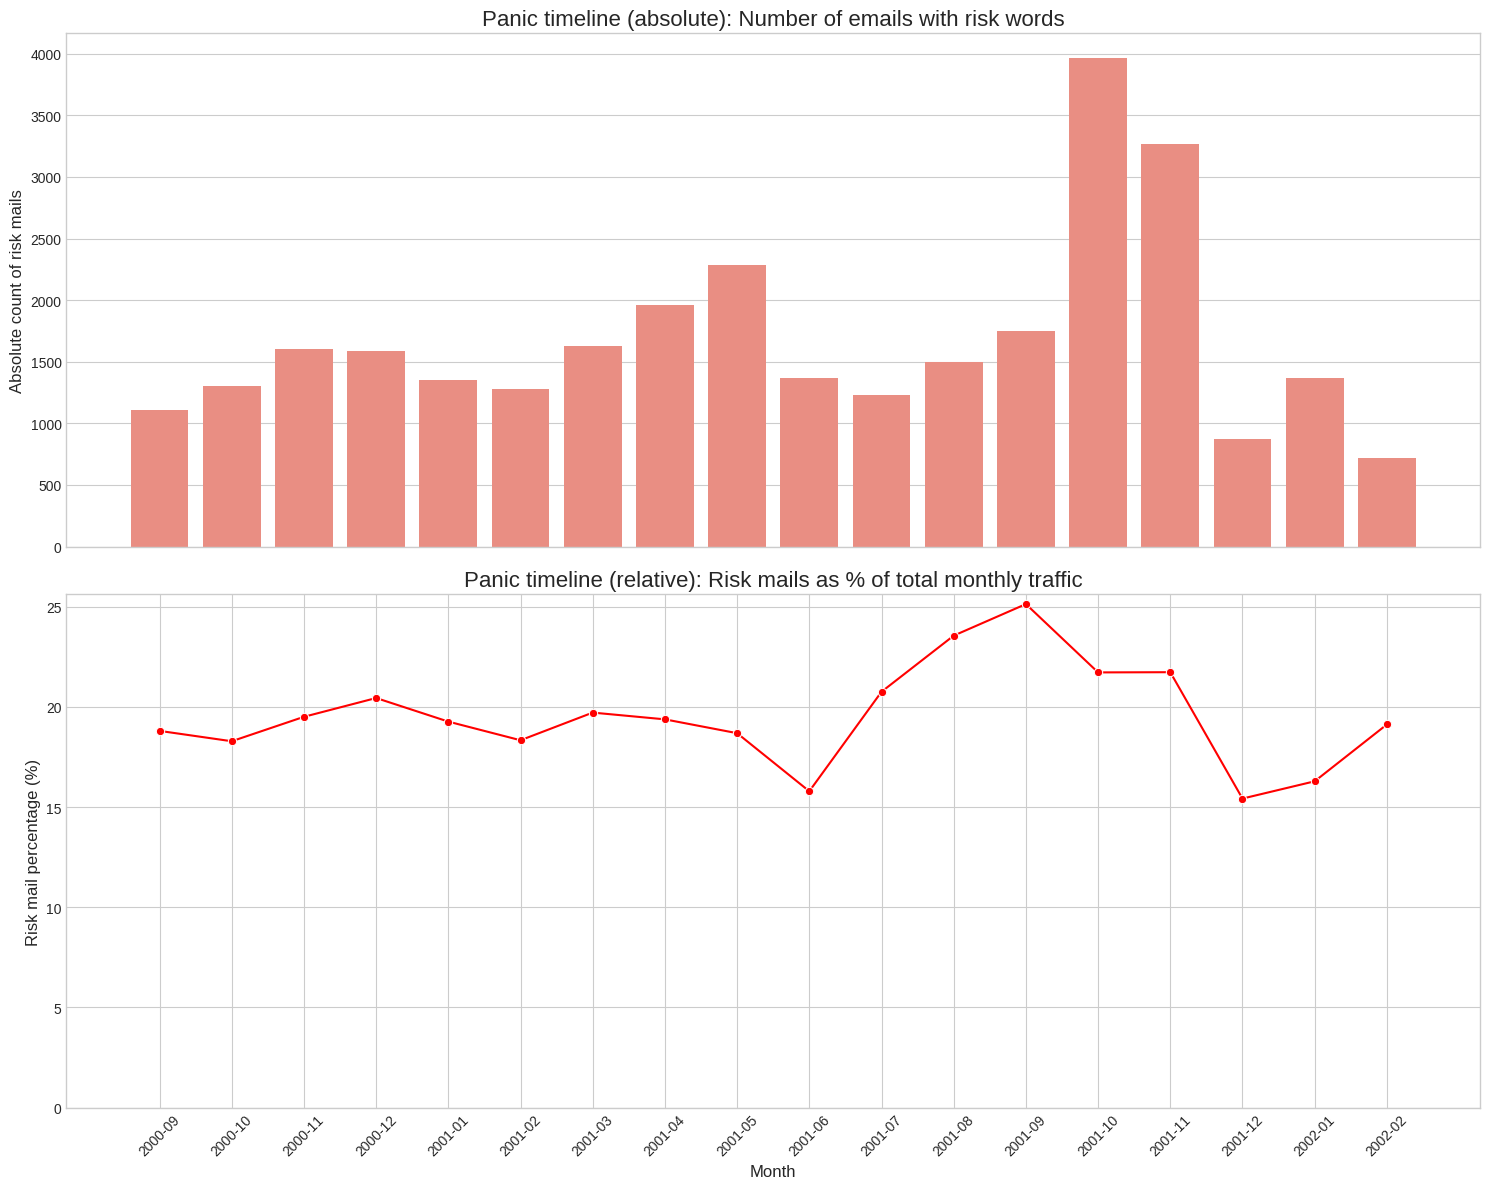

Combined data exported to analysis_results/panic_timeline_combined.csv
Combined chart image saved.


In [22]:
### 19 The 'Panic-Timeline' (absolute and relative)

print("Generating 'Panic Timeline' analysis...")
start_time = time.time()

# 1. Prepare database: Add persistent column for found risk words
sql_prep_db = """
ALTER TABLE emails_clean 
ADD COLUMN IF NOT EXISTS found_risk_words TEXT[];
"""
with db.connect() as conn:
    conn.execute(text(sql_prep_db))
    conn.commit()

# 2. Populate the column: Scan for each keyword and tag matches
print(f"Scanning {len(RISK_KEYWORDS)} risk patterns across the entire dataset (this might take a moment)...")

for pattern in RISK_KEYWORDS:
    # Clean the tag (e.g., '%shred%' -> 'shred')
    tag = pattern.replace('%', '').lower()
    
    # Append tag if it matches and isn't already there
    sql_tagging = """
    UPDATE emails_clean 
    SET found_risk_words = array_append(COALESCE(found_risk_words, ARRAY[]::text[]), :tag)
    WHERE 
        body_text ILIKE :pattern 
        AND NOT (COALESCE(found_risk_words, ARRAY[]::text[]) @> ARRAY[:tag]::text[]);
    """
    with db.connect() as conn:
        conn.execute(text(sql_tagging), {'pattern': pattern, 'tag': tag})
        conn.commit()

# 3. Create index for speed
with db.connect() as conn:
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_risk_words ON emails_clean USING GIN (found_risk_words);"))
    conn.commit()

print(f"Deep scan complete. Risk words tagged in database. (Time: {time.time() - start_time:.2f}s)")

# 4. Run the analysis using the new pre-calculated data
sql_panic_and_total_timeline = """
WITH monthly_traffic AS (
    SELECT
        TO_CHAR(sent_at_utc, 'YYYY-MM') as month,
        -- Now checking the array length instead of raw text scan
        COUNT(*) FILTER (WHERE array_length(found_risk_words, 1) > 0) as risk_mail_count,
        COUNT(*) as total_mail_count
    FROM
        emails_clean
    WHERE
        sender_clean IN (SELECT email FROM circle_of_interest)
        AND sent_at_utc BETWEEN :start_date AND :end_date
    GROUP BY
        month
)
SELECT
    month,
    risk_mail_count,
    total_mail_count,
    (risk_mail_count::FLOAT / NULLIF(total_mail_count, 0)) * 100 as risk_percentage
FROM
    monthly_traffic
ORDER BY
    month;
"""

df_timeline = pd.read_sql(
    text(sql_panic_and_total_timeline),
    db,
    params={
        'start_date': CRISIS_VIS_START_DATE,
        'end_date': CRISIS_VIS_END_DATE
    }
)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)
plt.style.use('seaborn-v0_8-whitegrid')

sns.barplot(data=df_timeline, x='month', y='risk_mail_count', color='salmon', ax=ax1)
ax1.set_title('Panic timeline (absolute): Number of emails with risk words', fontsize=16)
ax1.set_ylabel('Absolute count of risk mails', fontsize=12)

sns.lineplot(data=df_timeline, x='month', y='risk_percentage', marker='o', color='red', ax=ax2)
ax2.set_title('Panic timeline (relative): Risk mails as % of total monthly traffic', fontsize=16)
ax2.set_xlabel('Month', fontsize=12)
ax2.set_ylabel('Risk mail percentage (%)', fontsize=12)
ax2.set_ylim(0)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


export_path = "analysis_results/panic_timeline_combined.csv"
df_timeline.to_csv(export_path, index=False)
print(f"Combined data exported to {export_path}")

fig.savefig("analysis_results/panic_timeline_combined.png")
print("Combined chart image saved.")

In [23]:
### 20 Identify 'Panic Actors' (risk words)

sql_panic_authors_display = """
SELECT
    sender_clean as sender, 
    MIN(sender) as original_sender_example, 
    COUNT(*) as risk_mail_count
FROM
    emails_clean
WHERE
    sender_clean IN (SELECT email FROM circle_of_interest)
    AND body_text ILIKE ANY (:keywords)
    AND sent_at_utc BETWEEN :start_date AND :end_date
GROUP BY
    sender_clean
ORDER BY
    risk_mail_count DESC
LIMIT :limit;
"""

print(f"\nIdentifying Top {TOP_N_DISPLAY} 'Panic authors' during the meltdown ({CRISIS_START_DATE} to {CRISIS_END_DATE})...")

df_panic_authors = pd.read_sql(
    text(sql_panic_authors_display), 
    db, 
    params={
        'keywords': RISK_KEYWORDS,
        'start_date': CRISIS_START_DATE,
        'end_date': CRISIS_END_DATE,
        'limit': TOP_N_DISPLAY
    }
)

display(df_panic_authors[['sender', 'original_sender_example', 'risk_mail_count']])

# Export for Tableau
df_panic_authors_export = df_panic_authors[['sender', 'risk_mail_count']]
export_path = "analysis_results/panic_authors_peak.csv"
df_panic_authors_export.to_csv(export_path, index=False)
print(f"Data for Tableau exported to {export_path}")


Identifying Top 20 'Panic authors' during the meltdown (2001-10-01 to 2001-11-30)...


,sender,original_sender_example,risk_mail_count
0,matthew.lenhart@enron.com,matthew.lenhart@enron.com,278
1,jeff.dasovich@enron.com,jeff.dasovich@enron.com,214
2,d..steffes@enron.com,d..steffes@enron.com,182
3,sara.shackleton@enron.com,sara.shackleton@enron.com,126
4,marie.heard@enron.com,marie.heard@enron.com,104
5,rod.hayslett@enron.com,rod.hayslett@enron.com,96
6,james.derrick@enron.com,james.derrick@enron.com,80
7,mark.whitt@enron.com,mark.whitt@enron.com,68
8,j.kaminski@enron.com,j.kaminski@enron.com,63
9,michelle.cash@enron.com,michelle.cash@enron.com,63


Data for Tableau exported to analysis_results/panic_authors_peak.csv


In [24]:
### 21 Export risk-words dossiers for LLM analysis


top_authors_to_export = df_panic_authors_export['sender'].head(TOP_N_EXPORT).tolist()
print(f"Identified top {len(top_authors_to_export)} authors for dossier export: {top_authors_to_export}")

sql_fetch_dossiers = """
    SELECT 
        message_id, sent_at_utc, sender, sender_clean, recipients, subject, body_text
    FROM emails_clean
    WHERE 
        sender_clean = ANY(:authors)
        AND sent_at_utc BETWEEN :start_date AND :end_date
        AND body_text ILIKE ANY (:keywords)
    ORDER BY sender_clean, sent_at_utc;
"""
df_dossiers = pd.read_sql(
    text(sql_fetch_dossiers), 
    db, 
    params={'authors': top_authors_to_export, 'keywords': RISK_KEYWORDS, 'start_date': CRISIS_START_DATE, 'end_date': CRISIS_END_DATE}
)
print(f"Fetched {len(df_dossiers)} total emails for export.")

output_dir_dossiers = "analysis_results/crisis_dossiers_for_llm"
os.makedirs(output_dir_dossiers, exist_ok=True)
print(f"\n--- Writing individual dossiers to '{output_dir_dossiers}' ---")

for author in top_authors_to_export:
    df_author_dossier = df_dossiers[df_dossiers['sender_clean'] == author]
    
    if df_author_dossier.empty: continue

    author_filename = author.split('@')[0].replace('.', '_')
    export_path = os.path.join(output_dir_dossiers, f"{author_filename}_crisis_dossier.txt")
    
    with open(export_path, "w", encoding="utf-8") as f:
        f.write(f"FORENSIC DOSSIER FOR: {author}\nPERIOD: {CRISIS_START_DATE} to {CRISIS_END_DATE}\n\n")
        for _, row in df_author_dossier.iterrows():
            f.write("="*80 + f"\nEVIDENCE ID (Message-ID): {row['message_id']}\n" + "="*80 + "\n")
            f.write(f"Date: {row['sent_at_utc']}\nFrom: {row['sender']}\nTo: {row['recipients']}\nSubject: {row['subject']}\n")
            f.write("-" * 80 + f"\n\n{row['body_text']}\n\n\n")

    print(f"-> Exported {len(df_author_dossier)} evidence items for {author}.")

print("\nDossier export complete.")


Identified top 5 authors for dossier export: ['matthew.lenhart@enron.com', 'jeff.dasovich@enron.com', 'd..steffes@enron.com', 'sara.shackleton@enron.com', 'marie.heard@enron.com']
Fetched 904 total emails for export.

--- Writing individual dossiers to 'analysis_results/crisis_dossiers_for_llm' ---
-> Exported 278 evidence items for matthew.lenhart@enron.com.
-> Exported 214 evidence items for jeff.dasovich@enron.com.
-> Exported 182 evidence items for d..steffes@enron.com.
-> Exported 126 evidence items for sara.shackleton@enron.com.
-> Exported 104 evidence items for marie.heard@enron.com.

Dossier export complete.


In [25]:
### 22 Export data for Tableau treemap (filter funnel)


print("Generating data for the 'Filter funnel' visualization (treemap)...")
start_time_funnel = time.time()

sql_waste_metrics = """
SELECT 
    (SELECT COUNT(*) FROM emails) as raw_total,
    (SELECT COUNT(*) FROM emails WHERE noise_type IS NOT NULL) as noise_total,
    (SELECT COUNT(*) FROM emails_clean) as clean_total
"""
df_waste = pd.read_sql(text(sql_waste_metrics), db)

raw_total = df_waste.iloc[0]['raw_total']
noise_total = df_waste.iloc[0]['noise_total']
clean_total = df_waste.iloc[0]['clean_total']
duplicates_total = raw_total - noise_total - clean_total

# Categorize the clean traffic
sql_funnel_categorization = """
SELECT
    CASE
        WHEN (sender_clean NOT IN (SELECT email FROM circle_of_interest))
             OR
             NOT EXISTS (SELECT 1 FROM unnest(recipients_clean) r WHERE r IN (SELECT email FROM circle_of_interest))
        THEN 'Peripheral'
        WHEN (array_length(found_risk_words, 1) > 0) 
             AND (
                EXTRACT(HOUR FROM sent_at_utc) BETWEEN :sh_start AND :sh_end 
                OR EXTRACT(ISODOW FROM sent_at_utc) IN :sh_days
             ) THEN 'Intersection'
        WHEN (array_length(found_risk_words, 1) > 0) THEN 'RiskOnly'
        WHEN (
            EXTRACT(HOUR FROM sent_at_utc) BETWEEN :sh_start AND :sh_end 
            OR EXTRACT(ISODOW FROM sent_at_utc) IN :sh_days
        ) THEN 'ShadowOnly'
        ELSE 'Routine'
    END as category,
    COUNT(*) as volume
FROM emails_clean
WHERE cardinality(recipients_clean) <= 5
GROUP BY 1;
"""

df_cat = pd.read_sql(
    text(sql_funnel_categorization), 
    db, 
    params={
        'sh_start': SHADOW_START_HOUR,       
        'sh_end': SHADOW_END_HOUR,           
        'sh_days': SHADOW_WEEKEND_DAYS       
    }
)

treemap_data = []

# Group by numbers to force correct sorting in Tableau
for _, row in df_cat.iterrows():
    cat = row['category']
    vol = row['volume']
    
    if cat == 'Peripheral':
        treemap_data.append(['1. Non-relevant', 'Peripheral', 'Peripheral (outside/mixed)', vol, 'Blue light'])
    elif cat == 'Routine':
        treemap_data.append(['2. Relevant (Inner circle)', 'Inner circle', 'Inner circle (routine)', vol, 'Blue medium'])
    elif cat == 'ShadowOnly':
        treemap_data.append(['2. Relevant (Inner circle)', 'Inner circle', 'Inner circle (shadow)', vol, 'Purple'])
    elif cat == 'RiskOnly':
        treemap_data.append(['2. Relevant (Inner circle)', 'Inner circle', 'Inner circle (risk)', vol, 'Orange'])
    elif cat == 'Intersection':
        treemap_data.append(['2. Relevant (Inner circle)', 'Inner circle', 'CRITICAL (risk & shadow)', vol, 'Red'])

# Add waste to 'non-relevant'
treemap_data.append(['1. Non-relevant', 'Filtered data', 'Noise & spam', noise_total, 'Grey'])
treemap_data.append(['1. Non-relevant', 'Filtered data', 'Technical duplicates', duplicates_total, 'Grey'])

df_treemap = pd.DataFrame(treemap_data, columns=['L1_Level', 'L2_Group', 'L3_Detail', 'Volume', 'Color'])


# Add the mails with > 5 recipients to 'Peripheral'
total_in_treemap = df_treemap['Volume'].sum() - (noise_total + duplicates_total)
mails_over_5_recipients = clean_total - total_in_treemap
if mails_over_5_recipients > 0:
    peripheral_index = df_treemap.index[df_treemap['L3_Detail'] == 'Peripheral (outside/mixed)'][0]
    df_treemap.loc[peripheral_index, 'Volume'] += mails_over_5_recipients


export_path = "analysis_results/tableau_funnel_final.csv"
df_treemap.to_csv(export_path, index=False)

print(f"Export complete: {export_path}")
print(f"Total time: {time.time() - start_time_funnel:.2f}s")
display(df_treemap)

Generating data for the 'Filter funnel' visualization (treemap)...
Export complete: analysis_results/tableau_funnel_final.csv
Total time: 10.30s


,L1_Level,L2_Group,L3_Detail,Volume,Color
0,1. Non-relevant,Peripheral,Peripheral (outside/mixed),124097,Blue light
1,2. Relevant (Inner circle),Inner circle,CRITICAL (risk & shadow),1559,Red
2,2. Relevant (Inner circle),Inner circle,Inner circle (routine),94991,Blue medium
3,2. Relevant (Inner circle),Inner circle,Inner circle (shadow),5023,Purple
4,2. Relevant (Inner circle),Inner circle,Inner circle (risk),23270,Orange
5,1. Non-relevant,Filtered data,Noise & spam,23643,Grey
6,1. Non-relevant,Filtered data,Technical duplicates,244818,Grey


In [26]:
### 23 Export exclusive timelines for dashboard


print("Exporting exclusive timelines (Risk Only, Shadow Only, Intersection)...")

sql_exclusive_timelines = """
WITH flagged_traffic AS (
    SELECT
        TO_CHAR(sent_at_utc, 'YYYY-MM') as month,
        COALESCE((array_length(found_risk_words, 1) > 0), FALSE) as is_risk,
        (
            EXTRACT(HOUR FROM sent_at_utc) BETWEEN :sh_start AND :sh_end 
            OR EXTRACT(ISODOW FROM sent_at_utc) IN :sh_days
        ) as is_shadow
    FROM emails_clean
    WHERE
        cardinality(recipients_clean) <= 5 AND
        (sender_clean IN (SELECT email FROM circle_of_interest)) AND
        EXISTS (SELECT 1 FROM unnest(recipients_clean) r WHERE r IN (SELECT email FROM circle_of_interest))
        AND sent_at_utc BETWEEN :start_date AND :end_date
)
SELECT
    month,
    COUNT(*) FILTER (WHERE is_risk AND NOT is_shadow) as risk_only_count,
    COUNT(*) FILTER (WHERE is_shadow AND NOT is_risk) as shadow_only_count,
    COUNT(*) FILTER (WHERE is_risk AND is_shadow) as intersection_count,
    COUNT(*) as total_in_circle
FROM flagged_traffic
GROUP BY month
ORDER BY month;
"""

df_timelines = pd.read_sql(
    text(sql_exclusive_timelines),
    db,
    params={
        'start_date': SHADOW_START_DATE, 
        'end_date': SHADOW_END_DATE,
        'sh_start': SHADOW_START_HOUR,
        'sh_end': SHADOW_END_HOUR,
        'sh_days': SHADOW_WEEKEND_DAYS
    }
)

export_path = "analysis_results/dashboard_exclusive_timelines.csv"
df_timelines.to_csv(export_path, index=False)
print(f"Export complete: {export_path}")
display(df_timelines.head())

Exporting exclusive timelines (Risk Only, Shadow Only, Intersection)...
Export complete: analysis_results/dashboard_exclusive_timelines.csv


,month,risk_only_count,shadow_only_count,intersection_count,total_in_circle
0,2000-09,753,126,44,4016
1,2000-10,917,165,54,4987
2,2000-11,1094,188,58,5584
3,2000-12,1038,246,44,5221
4,2001-01,914,196,52,4706


In [27]:
### 24 Export intersection dossiers for LLM

print("Identifying and exporting dossiers for the 'CRITICAL (risk & shadow)' intersection...")

# Override export limit to 10. Due to low volume in this category,
# all top dossiers are processed as a single batch by a dedicated LLM agent.
TOP_N_EXPORT=10  

sql_top_intersection_authors = """
SELECT
    sender_clean as author,
    COUNT(*) as intersection_mail_count
FROM
    emails_clean
WHERE
    (array_length(found_risk_words, 1) > 0)
    AND (
        EXTRACT(HOUR FROM sent_at_utc) BETWEEN :sh_start AND :sh_end 
        OR EXTRACT(ISODOW FROM sent_at_utc) IN :sh_days
    )
    AND cardinality(recipients_clean) <= 5
    AND (sender_clean IN (SELECT email FROM circle_of_interest))
    AND EXISTS (SELECT 1 FROM unnest(recipients_clean) r WHERE r IN (SELECT email FROM circle_of_interest))
    AND sent_at_utc BETWEEN :start_date AND :end_date
GROUP BY
    sender_clean
ORDER BY
    intersection_mail_count DESC
LIMIT :limit;
"""

print(f"Finding top {TOP_N_EXPORT} authors...")
df_top_authors = pd.read_sql(
    text(sql_top_intersection_authors),
    db,
    params={
        'sh_start': SHADOW_START_HOUR,
        'sh_end': SHADOW_END_HOUR,
        'sh_days': SHADOW_WEEKEND_DAYS,
        'start_date': CRISIS_START_DATE,
        'end_date': CRISIS_END_DATE,
        'limit': TOP_N_EXPORT
    }
)

if df_top_authors.empty:
    print("No authors found matching the intersection criteria in the given period.")
else:
    display(df_top_authors)
    top_intersection_authors = df_top_authors['author'].tolist()

    output_dir_intersection = "analysis_results/intersection_dossiers_for_llm"
    os.makedirs(output_dir_intersection, exist_ok=True)
    print(f"\nExporting dossiers to '{output_dir_intersection}'...")

    sql_fetch_dossiers = """
        SELECT 
            message_id, sent_at_utc, sender, sender_clean, recipients, subject, body_text
        FROM emails_clean
        WHERE 
            sender_clean = ANY(:authors)
            AND (array_length(found_risk_words, 1) > 0)
            AND (
                EXTRACT(HOUR FROM sent_at_utc) BETWEEN :sh_start AND :sh_end 
                OR EXTRACT(ISODOW FROM sent_at_utc) IN :sh_days
            )
            AND cardinality(recipients_clean) <= 5
            AND (sender_clean IN (SELECT email FROM circle_of_interest))
            AND EXISTS (SELECT 1 FROM unnest(recipients_clean) r WHERE r IN (SELECT email FROM circle_of_interest))
            AND sent_at_utc BETWEEN :start_date AND :end_date
        ORDER BY sender_clean, sent_at_utc;
    """
    
    df_dossiers = pd.read_sql(
        text(sql_fetch_dossiers), 
        db, 
        params={
            'authors': top_intersection_authors,
            'sh_start': SHADOW_START_HOUR,
            'sh_end': SHADOW_END_HOUR,
            'sh_days': SHADOW_WEEKEND_DAYS,
            'start_date': SHADOW_START_DATE,
            'end_date': SHADOW_END_DATE
        }
    )

    for author in top_intersection_authors:
        df_author_dossier = df_dossiers[df_dossiers['sender_clean'] == author]
        
        if df_author_dossier.empty: continue

        author_filename = author.split('@')[0].replace('.', '_')
        export_path = os.path.join(output_dir_intersection, f"{author_filename}_intersection_dossier.txt")
        
        with open(export_path, "w", encoding="utf-8") as f:
            f.write(f"FORENSIC DOSSIER (INTERSECTION) FOR: {author}\n")
            f.write(f"PERIOD: {CRISIS_START_DATE} to {CRISIS_END_DATE}\n")
            f.write(f"CRITERIA: Sent during 'dead zone' AND contains risk keywords.\n\n")
            
            for _, row in df_author_dossier.iterrows():
                f.write("="*80 + f"\nEVIDENCE ID (Message-ID): {row['message_id']}\n" + "="*80 + "\n")
                f.write(f"Date: {row['sent_at_utc']}\nFrom: {row['sender']}\nTo: {row['recipients']}\nSubject: {row['subject']}\n")
                f.write("-" * 80 + f"\n\n{row['body_text']}\n\n\n")

        print(f"-> Exported {len(df_author_dossier)} evidence items for {author}.")

    print("\nIntersection dossier export complete.")

Identifying and exporting dossiers for the 'CRITICAL (risk & shadow)' intersection...
Finding top 10 authors...


,author,intersection_mail_count
0,james.derrick@enron.com,16
1,michelle.cash@enron.com,12
2,enerfaxdaily@enerfax.com,9
3,jeff.dasovich@enron.com,8
4,vkaminski@aol.com,8
5,b..sanders@enron.com,7
6,louise.kitchen@enron.com,6
7,rod.hayslett@enron.com,5
8,sally.beck@enron.com,5
9,7409950@skytel.com,5



Exporting dossiers to 'analysis_results/intersection_dossiers_for_llm'...
-> Exported 25 evidence items for james.derrick@enron.com.
-> Exported 27 evidence items for michelle.cash@enron.com.
-> Exported 16 evidence items for enerfaxdaily@enerfax.com.
-> Exported 37 evidence items for jeff.dasovich@enron.com.
-> Exported 45 evidence items for vkaminski@aol.com.
-> Exported 23 evidence items for b..sanders@enron.com.
-> Exported 24 evidence items for louise.kitchen@enron.com.
-> Exported 5 evidence items for rod.hayslett@enron.com.
-> Exported 11 evidence items for sally.beck@enron.com.
-> Exported 5 evidence items for 7409950@skytel.com.

Intersection dossier export complete.
